In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.5 MB/s eta 0:00:00


### Defining seven basis function for RBF network comparision:

In [1]:
import numpy as np
# Define seven basis functions
def gaussian(x, c, s):
    return np.exp(-np.linalg.norm(x - c, axis=1)**2 / (2 * s**2))

def multiquadratic(x, c, s):
    return np.sqrt(np.linalg.norm(x - c, axis=1)**2 + s**2)

def inverse_multiquadratic(x, c, s):
    return 1 / np.sqrt(np.linalg.norm(x - c, axis=1)**2 + s**2)

def thin_plate_spline(x, c, s):
    r = np.linalg.norm(x - c, axis=1)
    return (r**2) * np.log(r + 1e-6)  # Added small constant to avoid log(0)

def logistic(x, c, s):
    return 1 / (1 + np.exp(-np.linalg.norm(x - c, axis=1) / s))

def cubic(x, c, s):
    return np.linalg.norm(x - c, axis=1)**3

def linear(x, c, s):
    return np.linalg.norm(x - c, axis=1)

## Comparision between traditional backprop and moore-penrose inverse (gaussian as the basis function)

### training with backprop:

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

# Set random seed
np.random.seed(42)

# Load dataset
df = pd.read_csv("SENSEX_normalized.csv")

# Define features and target
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators].values
y = df["Direction"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RBFN with K-means-based initialization and backpropagation
class RBFN_Backprop:
    def __init__(self, input_dim, num_neurons, X_train, lr=0.01):
        self.num_neurons = num_neurons
        self.lr = lr

        # Initialize centers using K-means
        kmeans = KMeans(n_clusters=num_neurons, random_state=42).fit(X_train)
        self.centers = kmeans.cluster_centers_

        # Initialize sigma as distance to nearest center
        self.sigma = np.zeros(num_neurons)
        for i in range(num_neurons):
            dists = np.linalg.norm(self.centers[i] - np.delete(self.centers, i, axis=0), axis=1)
            self.sigma[i] = np.min(dists)
        self.sigma[self.sigma == 0] = 1e-4  # Avoid zero division

        # Initialize weights
        self.weights = np.random.randn(num_neurons)

    def gaussian(self, x, c, sigma):
        return np.exp(-np.linalg.norm(x - c, axis=1)**2 / (2 * sigma**2))

    def _rbf_layer(self, X):
        G = np.zeros((X.shape[0], self.num_neurons))
        for i in range(self.num_neurons):
            G[:, i] = self.gaussian(X, self.centers[i], self.sigma[i])
        return G

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def forward(self, X):
        self.G = self._rbf_layer(X)
        self.output = self.sigmoid(np.dot(self.G, self.weights))
        return self.output

    def backward(self, X, y_true):
        m = X.shape[0]
        error = self.output - y_true
        grad_w = np.dot(self.G.T, error) / m

        grad_c = np.zeros_like(self.centers)
        grad_s = np.zeros_like(self.sigma)

        for i in range(self.num_neurons):
            diff = X - self.centers[i]
            g_i = self.G[:, i]
            common_term = error * self.weights[i] * g_i
            grad_c[i] = np.sum((common_term[:, None] * diff) / (self.sigma[i] ** 2), axis=0) / m
            grad_s[i] = np.sum(common_term * np.linalg.norm(diff, axis=1) ** 2 / (self.sigma[i] ** 3)) / m

        # Update
        self.weights -= self.lr * grad_w
        self.centers -= self.lr * grad_c
        self.sigma -= self.lr * grad_s

    def train(self, X, y, epochs=50):
        for _ in range(epochs):
            self.forward(X)
            self.backward(X, y)

    def predict(self, X):
        probs = self.forward(X)
        return (probs > 0.5).astype(int)

# Use only Gaussian basis
# basis_functions = ["multiquadratic"]
basis_functions = ["gaussian", "multiquadratic", "inverse_multiquadratic",
                   "thin_plate_spline", "logistic", "cubic", "linear"]
hidden_neurons_list = range(10, 200, 5)
num_runs = 20

results = {basis: [] for basis in basis_functions}

for num_neurons in hidden_neurons_list:
    for basis in basis_functions:
        acc_scores = []
        f1_scores = []
        for _ in range(num_runs):
            model = RBFN_Backprop(input_dim=X.shape[1], num_neurons=num_neurons, X_train=X_train, lr=0.05)
            model.train(X_train, y_train, epochs=25)

            y_pred = model.predict(X_test)
            acc_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

        results[basis].append((num_neurons, np.mean(acc_scores), np.mean(f1_scores)))

# Plotting
hidden_sizes = {basis: [res[0] for res in results[basis]] for basis in basis_functions}
accuracy_dict = {basis: [res[1] for res in results[basis]] for basis in basis_functions}
f1_dict = {basis: [res[2] for res in results[basis]] for basis in basis_functions}

fig_accuracy = go.Figure()
for basis in basis_functions:
    fig_accuracy.add_trace(go.Scatter(x=hidden_sizes[basis], y=accuracy_dict[basis],
                                      mode="lines+markers", name=f"{basis} Accuracy"))
fig_accuracy.update_layout(title="Accuracy vs Hidden Neurons (Backprop RBFN)",
                           xaxis_title="Hidden Neurons", yaxis_title="Accuracy",
                           template="plotly_white", hovermode="x unified")
fig_accuracy.show()

# F1 Score plot
fig_f1 = go.Figure()
for basis in basis_functions:
    fig_f1.add_trace(go.Scatter(x=hidden_sizes[basis], y=f1_dict[basis],
                                mode="lines+markers", name=f"{basis} F1-Score"))
fig_f1.update_layout(title="F1-Score vs Hidden Neurons (Backprop RBFN)",
                     xaxis_title="Hidden Neurons", yaxis_title="F1-Score",
                     template="plotly_white", hovermode="x unified")
fig_f1.show()


## moore penrose

### RBFN Architecture:

In [3]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# RBF Network class
class RBFN:
    def __init__(self, num_neurons=10, basis_function='gaussian', reg_param=0.01):
        self.num_neurons = num_neurons
        self.basis_function = basis_function
        self.reg_param = reg_param
        self.centers = None
        self.sigma = None
        self.weights = None

    def _apply_basis_function(self, x):
        phi_matrix = np.zeros((x.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            if self.basis_function == 'gaussian':
                phi_matrix[:, i] = gaussian(x, center, self.sigma)
            elif self.basis_function == 'multiquadratic':
                phi_matrix[:, i] = multiquadratic(x, center, self.sigma)
            elif self.basis_function == 'inverse_multiquadratic':
                phi_matrix[:, i] = inverse_multiquadratic(x, center, self.sigma)
            elif self.basis_function == 'thin_plate_spline':
                phi_matrix[:, i] = thin_plate_spline(x, center, self.sigma)
            elif self.basis_function == 'logistic':
                phi_matrix[:, i] = logistic(x, center, self.sigma)
            elif self.basis_function == 'cubic':
                phi_matrix[:, i] = cubic(x, center, self.sigma)
            elif self.basis_function == 'linear':
                phi_matrix[:, i] = linear(x, center, self.sigma)
        return phi_matrix

    def fit(self, X, y):
        # Step 1: Compute centers using K-means clustering
        if isinstance(X, pd.DataFrame):
            X = X.values
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Step 2: Compute sigma (width of RBFs)
        d_max = np.max([np.linalg.norm(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.sigma = d_max / np.sqrt(2 * self.num_neurons)

        # Step 3: Compute design matrix
        Phi = self._apply_basis_function(X)

        # Step 4: Compute weights using Ridge Regression
        I = np.identity(self.num_neurons)
        self.weights = np.linalg.inv(Phi.T @ Phi + self.reg_param * I) @ Phi.T @ y

    def predict(self, X):
        Phi = self._apply_basis_function(X)
        y_pred = Phi @ self.weights
        return (y_pred > 0.5).astype(int)  # Convert to binary class (0 or 1)

    def reset(self):
        self.centers = None
        self.sigma = None
        self.weights = None




## Comparision between 7 different basis functions:

In [4]:

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
df = pd.read_csv("SENSEX_normalized.csv")

# Define technical indicators and target variable
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define basis functions
basis_functions = ["gaussian", "multiquadratic", "inverse_multiquadratic",
                   "thin_plate_spline", "logistic", "cubic", "linear"]

# Define hidden neuron sizes to test
hidden_neurons_list = range(10, 200, 5)  # 10 to 200 with step size 5

# Initialize dictionary to store results
results = {basis: [] for basis in basis_functions}

# Number of runs for averaging
num_runs = 20

# Evaluate performance for different hidden neuron sizes
for num_neurons in hidden_neurons_list:
    for basis in basis_functions:
        accuracy_scores = []
        f1_scores = []

        for _ in range(num_runs):
            # Initialize and train the model
            model = RBFN(num_neurons=num_neurons, basis_function=basis, reg_param=0.06)
            model.fit(X_train, y_train)

            # Predict on the test set
            y_pred = model.predict(X_test)

            # Compute accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            # Store scores
            accuracy_scores.append(accuracy)
            f1_scores.append(f1)

        # Compute average performance
        avg_accuracy = np.mean(accuracy_scores)
        avg_f1 = np.mean(f1_scores)

        # Store results
        results[basis].append((num_neurons, avg_accuracy, avg_f1))

# Convert results for plotting
hidden_sizes = {basis: [res[0] for res in results[basis]] for basis in basis_functions}
accuracy_dict = {basis: [res[1] for res in results[basis]] for basis in basis_functions}
f1_dict = {basis: [res[2] for res in results[basis]] for basis in basis_functions}

# Plot Accuracy vs Hidden Neurons
fig_accuracy = go.Figure()
for basis in basis_functions:
    fig_accuracy.add_trace(go.Scatter(
        x=hidden_sizes[basis], y=accuracy_dict[basis],
        mode="lines+markers", name=f"{basis} Accuracy",
        line=dict(width=2),
        marker=dict(size=8)
    ))
fig_accuracy.update_layout(
    title="Effect of Hidden Neurons on Model Accuracy for All Basis Functions (20 Runs Average)",
    xaxis_title="Number of Hidden Neurons",
    yaxis_title="Accuracy",
    legend_title="Basis Function",
    template="plotly_white",
    hovermode="x unified"
)
fig_accuracy.show()

# Plot F1-Score vs Hidden Neurons
fig_f1 = go.Figure()
for basis in basis_functions:
    fig_f1.add_trace(go.Scatter(
        x=hidden_sizes[basis], y=f1_dict[basis],
        mode="lines+markers", name=f"{basis} F1-Score",
        line=dict(width=2),
        marker=dict(size=8)
    ))
fig_f1.update_layout(
    title="Effect of Hidden Neurons on Model F1-Score for All Basis Functions (20 Runs Average)",
    xaxis_title="Number of Hidden Neurons",
    yaxis_title="F1-Score",
    legend_title="Basis Function",
    template="plotly_white",
    hovermode="x unified"
)
fig_f1.show()


python(39979) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


# Comparison between RBF Networks and FRACTALIZED RBF Networks

## Gaussian RBF

[I 2025-05-19 10:58:52,261] A new study created in memory with name: no-name-b1d48160-9298-402e-bf66-448f0724525a
[I 2025-05-19 10:58:52,370] Trial 0 finished with value: 0.8671328671328671 and parameters: {'num_neurons': 191, 'gamma': 0.02484090312367012, 'reg_param': 4.03431936657503e-06}. Best is trial 0 with value: 0.8671328671328671.
[I 2025-05-19 10:58:52,395] Trial 1 finished with value: 0.8303249097472925 and parameters: {'num_neurons': 45, 'gamma': 1.1743979605871298, 'reg_param': 2.7014138007809777e-06}. Best is trial 0 with value: 0.8671328671328671.
[I 2025-05-19 10:58:52,444] Trial 2 finished with value: 0.7425474254742548 and parameters: {'num_neurons': 145, 'gamma': 0.001277951414961786, 'reg_param': 0.47624220970532477}. Best is trial 0 with value: 0.8671328671328671.
[I 2025-05-19 10:58:52,469] Trial 3 finished with value: 0.8458781362007168 and parameters: {'num_neurons': 44, 'gamma': 0.3126932927656767, 'reg_param': 0.000324098641602281}. Best is trial 0 with value: 

Best Hyperparameters: {'num_neurons': 176, 'gamma': 0.001659725728638572, 'reg_param': 1.745527890042758e-05}

Final Accuracy: 0.8607
Final F1 Score: 0.8819
Confusion Matrix:
[[ 83  22]
 [ 12 127]]


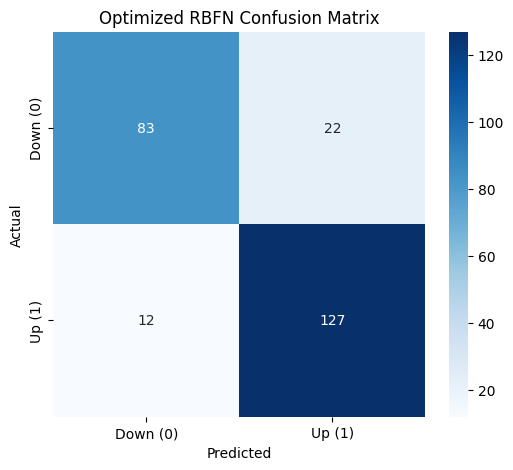

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import optuna

# Set seed
np.random.seed(42)

# Load dataset
df = pd.read_csv("SENSEX_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- RBFN Class with gamma ---
class RBFN:
    def __init__(self, num_neurons, gamma=1.0, reg_param=0.0):
        self.num_neurons = num_neurons
        self.gamma = gamma
        self.reg_param = reg_param

    def _basis(self, r):
        return np.exp(-self.gamma * r**2)

    def _calculate_matrix(self, X, centers):
        G = np.zeros((X.shape[0], centers.shape[0]))
        for i, center in enumerate(centers):
            r = np.linalg.norm(X - center, axis=1)
            G[:, i] = self._basis(r)
        return G

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_

        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))

        I = np.identity(G.shape[1])
        I[0, 0] = 0  # No regularization for bias
        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X):
        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_pred = G @ self.weights
        return (y_pred > 0.5).astype(int)

# --- Optuna Objective ---
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    gamma = trial.suggest_float("gamma", 0.001, 10.0, log=True)
    reg_param = trial.suggest_float("reg_param", 1e-6, 1.0, log=True)

    model = RBFN(num_neurons=num_neurons, gamma=gamma, reg_param=reg_param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

# --- Run Optuna ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# --- Best Params and Final Model ---
best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = RBFN(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# --- Metrics ---
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down (0)", "Up (1)"], yticklabels=["Down (0)", "Up (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized RBFN Confusion Matrix")
plt.show()


## Fractalized Gaussian RBF

In [6]:
# !pip install optuna
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import optuna

# Base RBF and base function
def classical_gaussian_rbf(r, center=0.0, gamma=1.0):
    return np.exp(-gamma * (r - center)**2)

def base_function(r, center=0.0, gamma=1.0):
    r0, r1 = 0, np.sqrt(6)
    phi0 = classical_gaussian_rbf(r0, center=center, gamma=gamma)
    phi1 = classical_gaussian_rbf(r1, center=center, gamma=gamma)
    return (phi1 - phi0) / (r1 - r0) * r + phi0

# Affine mapping functions
def u_i(i, r, intervals):
    a = (intervals[i] - intervals[i-1]) / (intervals[-1] - intervals[0])
    b = intervals[i-1] - a * intervals[0]
    return a * r + b

def v_i(i, r, t, alpha, intervals, center=0.0, gamma=1.0):
    phi_val = classical_gaussian_rbf(u_i(i, r, intervals), center=center, gamma=gamma)
    base_val = base_function(r, center=center, gamma=gamma)
    return phi_val + alpha[i-1] * (t - base_val)

# Fractal iteration with recursive point generation
def iterate_fractal_operator(alpha, intervals, center=0.0, gamma=1.0, max_iter=4):
    r_list = [np.array([0.0,np.sqrt(6)])]
    phi_dict = {}

    # Base evaluation
    r0 = r_list[0]
    phi0 = base_function(r0 , center=center, gamma=gamma)
    phi_dict[0] = phi0

    for d in range(1, max_iter + 1):
        r_prev = r_list[-1]
        r_new = []
        phi_new = []

        for i in range(1, len(intervals)):

            r_i = u_i(i, r_prev, intervals)
            t_i = phi_dict[d - 1]

            # Map inverse from u_i
            r_inv = (r_i - intervals[i-1]) / (intervals[i] - intervals[i-1])
            v_vals = v_i(i, r_inv, t_i, alpha, intervals, center=center, gamma=gamma)

            r_new.extend(r_i)
            phi_new.extend(v_vals)

        # Sort and deduplicate
        r_new = np.array(r_new)
        phi_new = np.array(phi_new)
        sort_idx = np.argsort(r_new)
        r_new = r_new[sort_idx]
        phi_new = phi_new[sort_idx]

        r_list.append(r_new)
        phi_dict[d] = phi_new

        # print(f"Iteration {d}: {len(r_new)} points")

    return r_list[-1], phi_dict[max_iter]  # Rescale back to r domain

# ----------------- RBF Model Class ------------------
class FractalizedRBFN_Gaussian:
    def __init__(self, num_neurons, alpha_list, reg_param=0.0, gamma=1.0, max_iter=4):
        self.num_neurons = num_neurons
        self.alpha_list = alpha_list
        self.reg_param = reg_param
        self.gamma = gamma
        self.intervals = [0, np.sqrt(6)/2, np.sqrt(6)]
        self.max_iter = max_iter


    def _fractalized_basis(self, r, center):
        r_vals, phi_vals = iterate_fractal_operator(
            self.alpha_list, self.intervals,
            center=center, gamma=self.gamma,
            max_iter=self.max_iter
        )
        return np.interp(r, r_vals, phi_vals)

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))  # bias
        I = np.identity(G.shape[1])
        I[0, 0] = 0  # no regularization on bias

        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X, return_proba=False):
        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_score = G @ self.weights

        if return_proba:
            return y_score  # raw scores
        else:
            return (y_score > 0.5).astype(int)

# ----------------- Optuna Hyperparameter Tuning ------------------
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    alpha1 = trial.suggest_float("alpha1", -0.5, 0.5)
    alpha2 = trial.suggest_float("alpha2", -0.5, 0.5)
    reg_param = trial.suggest_float("reg_param", 0.001, 0.1, log=True)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)
    max_iter = trial.suggest_int("max_iter", 3,10)


    model = FractalizedRBFN_Gaussian(
        num_neurons=num_neurons,
        alpha_list=[alpha1, alpha2],
        reg_param=reg_param,
        gamma=gamma,
        max_iter=max_iter
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

# ----------------- Load Data ------------------
df = pd.read_csv("SENSEX_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Run Optuna ------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# ----------------- Best Model Evaluation ------------------
best_params = study.best_params
best_model = FractalizedRBFN_Gaussian(
    num_neurons=best_params['num_neurons'],
    alpha_list=[best_params['alpha1'], best_params['alpha2']],
    reg_param=best_params['reg_param'],
    gamma=best_params['gamma'],
    max_iter=best_params['max_iter']
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict(X_test, return_proba=True)

# Evaluation Metrics
print("Best Params:", best_params)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



[I 2025-05-19 11:02:23,061] A new study created in memory with name: no-name-c03a0d68-40e5-4589-bd0e-435bde2d55e9
[I 2025-05-19 11:02:23,236] Trial 0 finished with value: 0.8256227758007118 and parameters: {'num_neurons': 177, 'alpha1': -0.10313430106700094, 'alpha2': -0.23739226634272426, 'reg_param': 0.04831563694079825, 'gamma': 2.4192637487838393, 'max_iter': 5}. Best is trial 0 with value: 0.8256227758007118.
[I 2025-05-19 11:02:23,363] Trial 1 finished with value: 0.759581881533101 and parameters: {'num_neurons': 145, 'alpha1': -0.11038177359731871, 'alpha2': 0.42216462444786007, 'reg_param': 0.032761501933521626, 'gamma': 0.9266467244268308, 'max_iter': 4}. Best is trial 0 with value: 0.8256227758007118.
[I 2025-05-19 11:02:23,417] Trial 2 finished with value: 0.7766323024054983 and parameters: {'num_neurons': 11, 'alpha1': 0.3867237650589189, 'alpha2': 0.4649763679857899, 'reg_param': 0.0027587960902102247, 'gamma': 4.788158541722364, 'max_iter': 10}. Best is trial 0 with value

Best Params: {'num_neurons': 72, 'alpha1': -0.011741932277217367, 'alpha2': 0.4514625622735067, 'reg_param': 0.031075711007402966, 'gamma': 4.744345674424954, 'max_iter': 3}
Accuracy: 0.8565573770491803
F1 Score: 0.8754448398576512
Confusion Matrix:
 [[ 86  19]
 [ 16 123]]


## multi-quadratic

[I 2025-05-19 11:05:57,761] A new study created in memory with name: no-name-69cb4d70-2d9d-4af8-8193-7a0e64aabc3e
[I 2025-05-19 11:05:57,795] Trial 0 finished with value: 0.7098976109215017 and parameters: {'num_neurons': 123, 'c': 1.0413189848123934, 'gamma': 0.005653204050512095, 'reg_param': 1.7961496989755765e-06}. Best is trial 0 with value: 0.7098976109215017.
[I 2025-05-19 11:05:57,833] Trial 1 finished with value: 0.8413793103448276 and parameters: {'num_neurons': 99, 'c': 6.79578273280385, 'gamma': 1.5669913090975636, 'reg_param': 0.01033927268712723}. Best is trial 1 with value: 0.8413793103448276.
[I 2025-05-19 11:05:57,887] Trial 2 finished with value: 0.8692579505300353 and parameters: {'num_neurons': 163, 'c': 1.1204249771859416, 'gamma': 0.2986841317792675, 'reg_param': 5.576868032805927e-06}. Best is trial 2 with value: 0.8692579505300353.
[I 2025-05-19 11:05:57,922] Trial 3 finished with value: 0.8321167883211679 and parameters: {'num_neurons': 105, 'c': 0.239219586572

Best Hyperparameters: {'num_neurons': 39, 'c': 0.264403488365732, 'gamma': 0.019762350012608995, 'reg_param': 7.526731640720128e-06}

Final Accuracy: 0.8607
Final F1 Score: 0.8819
Confusion Matrix:
[[ 83  22]
 [ 12 127]]


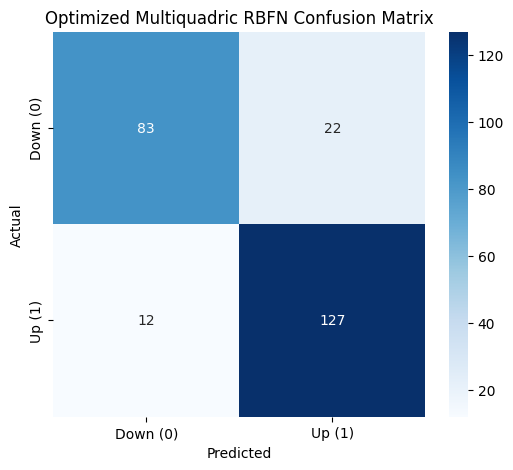

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import optuna

# Set seed
np.random.seed(42)

# Load dataset
df = pd.read_csv("SENSEX_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Multiquadric RBFN Class ---
class RBFN:
    def __init__(self, num_neurons, c=1.0, gamma=1.0, reg_param=0.0):
        self.num_neurons = num_neurons
        self.c = c  # Shape parameter for multiquadric
        self.gamma = gamma  # Scale parameter
        self.reg_param = reg_param

    def _basis(self, r):
        return np.sqrt(1 + (self.gamma * r / self.c)**2)

    def _calculate_matrix(self, X, centers):
        G = np.zeros((X.shape[0], centers.shape[0]))
        for i, center in enumerate(centers):
            r = np.linalg.norm(X - center, axis=1)
            G[:, i] = self._basis(r)
        return G

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_

        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))  # Add bias term

        I = np.identity(G.shape[1])
        I[0, 0] = 0  # No regularization for bias
        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X):
        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_pred = G @ self.weights
        return (y_pred > 0.5).astype(int)

# --- Optuna Objective ---
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    c = trial.suggest_float("c", 0.1, 10.0, log=True)  # Shape parameter
    gamma = trial.suggest_float("gamma", 0.001, 10.0, log=True)  # Scale parameter
    reg_param = trial.suggest_float("reg_param", 1e-6, 1.0, log=True)

    model = RBFN(num_neurons=num_neurons, c=c, gamma=gamma, reg_param=reg_param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

# --- Run Optuna ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# --- Best Params and Final Model ---
best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = RBFN(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# --- Metrics ---
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"],
            yticklabels=["Down (0)", "Up (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized Multiquadric RBFN Confusion Matrix")
plt.show()

## Fractalized multi-quadratic

In [8]:
# !pip install optuna
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import optuna

# Base RBF and base function - Modified for Multiquadric
def classical_multiquadric_rbf(r, center=0.0, c=1.0, gamma=1.0):
    return np.sqrt(1 + gamma * (r - center)**2 / c**2)

def base_function(r, center=0.0, c=1.0, gamma=1.0):
    r0, r1 = 0, np.sqrt(6)
    phi0 = classical_multiquadric_rbf(r0, center=center, c=c, gamma=gamma)
    phi1 = classical_multiquadric_rbf(r1, center=center, c=c, gamma=gamma)
    return (phi1 - phi0) / (r1 - r0) * r + phi0

# Affine mapping functions (unchanged)
def u_i(i, r, intervals):
    a = (intervals[i] - intervals[i-1]) / (intervals[-1] - intervals[0])
    b = intervals[i-1] - a * intervals[0]
    return a * r + b

def v_i(i, r, t, alpha, intervals, center=0.0, c=1.0, gamma=1.0):
    phi_val = classical_multiquadric_rbf(u_i(i, r, intervals), center=center, c=c, gamma=gamma)
    base_val = base_function(r, center=center, c=c, gamma=gamma)
    return phi_val + alpha[i-1] * (t - base_val)

# Fractal iteration with recursive point generation - Modified for Multiquadric
def iterate_fractal_operator(alpha, intervals, center=0.0, c=1.0, gamma=1.0, max_iter=4):
    r_list = [np.array([0.0,np.sqrt(6)])]
    phi_dict = {}

    # Base evaluation
    r0 = r_list[0]
    phi0 = base_function(r0, center=center, c=c, gamma=gamma)
    phi_dict[0] = phi0

    for d in range(1, max_iter + 1):
        r_prev = r_list[-1]
        r_new = []
        phi_new = []

        for i in range(1, len(intervals)):
            r_i = u_i(i, r_prev, intervals)
            t_i = phi_dict[d - 1]

            # Map inverse from u_i
            r_inv = (r_i - intervals[i-1]) / (intervals[i] - intervals[i-1])
            v_vals = v_i(i, r_inv, t_i, alpha, intervals, center=center, c=c, gamma=gamma)

            r_new.extend(r_i)
            phi_new.extend(v_vals)

        # Sort and deduplicate
        r_new = np.array(r_new)
        phi_new = np.array(phi_new)
        sort_idx = np.argsort(r_new)
        r_new = r_new[sort_idx]
        phi_new = phi_new[sort_idx]

        r_list.append(r_new)
        phi_dict[d] = phi_new

    return r_list[-1], phi_dict[max_iter]

# ----------------- RBF Model Class ------------------
class FractalizedRBFN_Multiquadric:
    def __init__(self, num_neurons, alpha_list, reg_param=0.0, c=1.0, gamma=1.0, max_iter=4):
        self.num_neurons = num_neurons
        self.alpha_list = alpha_list
        self.reg_param = reg_param
        self.c = c  # New shape parameter for multiquadric
        self.gamma = gamma
        self.intervals = [0, np.sqrt(6)/2, np.sqrt(6)]
        self.max_iter = max_iter

    def _fractalized_basis(self, r, center):
        r_vals, phi_vals = iterate_fractal_operator(
            self.alpha_list, self.intervals,
            center=center, c=self.c, gamma=self.gamma,
            max_iter=self.max_iter
        )
        return np.interp(r, r_vals, phi_vals)

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))  # bias
        I = np.identity(G.shape[1])
        I[0, 0] = 0  # no regularization on bias

        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X, return_proba=False):
        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_score = G @ self.weights

        if return_proba:
            return y_score  # raw scores
        else:
            return (y_score > 0.5).astype(int)

# ----------------- Optuna Hyperparameter Tuning ------------------
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    alpha1 = trial.suggest_float("alpha1", -0.5, 0.5)
    alpha2 = trial.suggest_float("alpha2", -0.5, 0.5)
    reg_param = trial.suggest_float("reg_param", 0.001, 0.1, log=True)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)
    c = trial.suggest_float("c", 0.1, 2.0)  # New parameter for multiquadric
    max_iter = trial.suggest_int("max_iter", 3,5)

    model = FractalizedRBFN_Multiquadric(
        num_neurons=num_neurons,
        alpha_list=[alpha1, alpha2],
        reg_param=reg_param,
        c=c,
        gamma=gamma,
        max_iter=max_iter
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

# ----------------- Load Data ------------------
df = pd.read_csv("SENSEX_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Run Optuna ------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# ----------------- Best Model Evaluation ------------------
best_params = study.best_params
best_model = FractalizedRBFN_Multiquadric(
    num_neurons=best_params['num_neurons'],
    alpha_list=[best_params['alpha1'], best_params['alpha2']],
    reg_param=best_params['reg_param'],
    c=best_params['c'],
    gamma=best_params['gamma'],
    max_iter=best_params['max_iter']
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict(X_test, return_proba=True)

# Evaluation Metrics
print("Best Params:", best_params)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[I 2025-05-19 11:08:10,736] A new study created in memory with name: no-name-c8de0a44-6d80-4fa2-9eda-24c95eaab817
[I 2025-05-19 11:08:10,887] Trial 0 finished with value: 0.7304964539007093 and parameters: {'num_neurons': 162, 'alpha1': -0.20297770391652725, 'alpha2': 0.12045389030276621, 'reg_param': 0.008628124696530012, 'gamma': 4.885441083551003, 'c': 1.5937893177350013, 'max_iter': 5}. Best is trial 0 with value: 0.7304964539007093.
[I 2025-05-19 11:08:10,953] Trial 1 finished with value: 0.7298245614035088 and parameters: {'num_neurons': 63, 'alpha1': -0.215930109621981, 'alpha2': -0.3063881285323523, 'reg_param': 0.08858846825902848, 'gamma': 1.87969214062506, 'c': 1.919842455713641, 'max_iter': 4}. Best is trial 0 with value: 0.7304964539007093.
[I 2025-05-19 11:08:10,984] Trial 2 finished with value: 0.7361111111111112 and parameters: {'num_neurons': 32, 'alpha1': -0.4955575872676079, 'alpha2': -0.3077857270424742, 'reg_param': 0.0035778452222571286, 'gamma': 0.509367335510796

Best Params: {'num_neurons': 156, 'alpha1': 0.0680039637227924, 'alpha2': 0.2733845562048265, 'reg_param': 0.04072066755383178, 'gamma': 4.60577899662415, 'c': 1.1619428744035893, 'max_iter': 3}
Accuracy: 0.8483606557377049
F1 Score: 0.8692579505300353
Confusion Matrix:
 [[ 84  21]
 [ 16 123]]


## Thin plate spline

[I 2025-05-19 11:16:09,148] A new study created in memory with name: no-name-87b5096e-5853-4796-82df-f1bb802f53f5
<ipython-input-9-afeaa2c8acb3>:28: RuntimeWarning: divide by zero encountered in log
  return np.where(r == 0, 0, r**2 * np.log(r))
<ipython-input-9-afeaa2c8acb3>:28: RuntimeWarning: invalid value encountered in multiply
  return np.where(r == 0, 0, r**2 * np.log(r))
[I 2025-05-19 11:16:09,385] Trial 0 finished with value: 0.8260869565217391 and parameters: {'num_neurons': 178, 'reg_param': 3.878689246079338e-06}. Best is trial 0 with value: 0.8260869565217391.
<ipython-input-9-afeaa2c8acb3>:28: RuntimeWarning: divide by zero encountered in log
  return np.where(r == 0, 0, r**2 * np.log(r))
<ipython-input-9-afeaa2c8acb3>:28: RuntimeWarning: invalid value encountered in multiply
  return np.where(r == 0, 0, r**2 * np.log(r))
[I 2025-05-19 11:16:09,472] Trial 1 finished with value: 0.850909090909091 and parameters: {'num_neurons': 118, 'reg_param': 0.041496187447995464}. Best

Best Hyperparameters: {'num_neurons': 97, 'reg_param': 0.11021844681524215}

Final Accuracy: 0.8402
Final F1 Score: 0.8602
Confusion Matrix:
[[ 85  20]
 [ 19 120]]


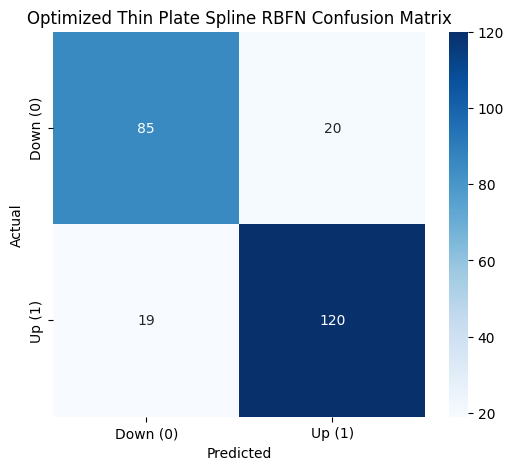

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import optuna

# Set seed
np.random.seed(42)

# Load dataset
df = pd.read_csv("SENSEX_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Thin Plate Spline RBFN Class ---
class TPS_RBFN:
    def __init__(self, num_neurons, reg_param=0.0):
        self.num_neurons = num_neurons
        self.reg_param = reg_param

    def _basis(self, r):
        """Thin Plate Spline basis function: r^2 * log(r)"""
        return np.where(r == 0, 0, r**2 * np.log(r))

    def _calculate_matrix(self, X, centers):
        G = np.zeros((X.shape[0], centers.shape[0]))
        for i, center in enumerate(centers):
            r = np.linalg.norm(X - center, axis=1)
            G[:, i] = self._basis(r)
        return G

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_

        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))  # Add bias term

        I = np.identity(G.shape[1])
        I[0, 0] = 0  # No regularization for bias
        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X):
        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_pred = G @ self.weights
        return (y_pred > 0.5).astype(int)

# --- Optuna Objective ---
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    reg_param = trial.suggest_float("reg_param", 1e-6, 1.0, log=True)

    model = TPS_RBFN(num_neurons=num_neurons, reg_param=reg_param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

# --- Run Optuna ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# --- Best Params and Final Model ---
best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = TPS_RBFN(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# --- Metrics ---
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"],
            yticklabels=["Down (0)", "Up (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized Thin Plate Spline RBFN Confusion Matrix")
plt.show()


## fractalized thin plate spline

In [10]:
# !pip install optuna
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import optuna

# Base RBF and base function - Thin Plate Spline
def classical_tps_rbf(r):
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.where(r == 0, 1e-10, r)
        return r**2 * np.log(r)

def base_function(r):
    r0, r1 = 0, np.sqrt(6)
    phi0 = classical_tps_rbf(r0)
    phi1 = classical_tps_rbf(r1)
    return (phi1 - phi0) / (r1 - r0) * r + phi0

# Affine mapping functions
def u_i(i, r, intervals):
    a = (intervals[i] - intervals[i-1]) / (intervals[-1] - intervals[0])
    b = intervals[i-1] - a * intervals[0]
    return a * r + b

def v_i(i, r, t, alpha, intervals):
    phi_val = classical_tps_rbf(u_i(i, r, intervals))
    base_val = base_function(r)
    return phi_val + alpha[i-1] * (t - base_val)

# Fractal iteration for TPS
def iterate_fractal_operator(alpha, intervals, max_iter=4):
    r_list = [np.array([0.0, np.sqrt(6)])]
    phi_dict = {}
    r0 = r_list[0]
    phi0 = base_function(r0)
    phi_dict[0] = phi0

    for d in range(1, max_iter + 1):
        r_prev = r_list[-1]
        r_new = []
        phi_new = []

        for i in range(1, len(intervals)):
            r_i = u_i(i, r_prev, intervals)
            t_i = phi_dict[d - 1]
            r_inv = (r_i - intervals[i-1]) / (intervals[i] - intervals[i-1])
            v_vals = v_i(i, r_inv, t_i, alpha, intervals)
            r_new.extend(r_i)
            phi_new.extend(v_vals)

        r_new = np.array(r_new)
        phi_new = np.array(phi_new)
        sort_idx = np.argsort(r_new)
        r_new = r_new[sort_idx]
        phi_new = phi_new[sort_idx]

        r_list.append(r_new)
        phi_dict[d] = phi_new

    return r_list[-1], phi_dict[max_iter]

# ----------------- RBF Model Class ------------------
class FractalizedRBFN_TPS:
    def __init__(self, num_neurons, alpha_list, reg_param=0.0, max_iter=4):
        self.num_neurons = num_neurons
        self.alpha_list = alpha_list
        self.reg_param = reg_param
        self.intervals = [0, np.sqrt(6)/2, np.sqrt(6)]
        self.max_iter = max_iter

    def _fractalized_basis(self, r, center):
        r_vals, phi_vals = iterate_fractal_operator(
            self.alpha_list, self.intervals,
            max_iter=self.max_iter
        )
        return np.interp(r, r_vals, phi_vals)

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))  # bias
        I = np.identity(G.shape[1])
        I[0, 0] = 0

        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X, return_proba=False):
        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_score = G @ self.weights

        if return_proba:
            return y_score
        else:
            return (y_score > 0.5).astype(int)

# ----------------- Optuna Hyperparameter Tuning ------------------
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    alpha1 = trial.suggest_float("alpha1", -0.5, 0.5)
    alpha2 = trial.suggest_float("alpha2", -0.5, 0.5)
    reg_param = trial.suggest_float("reg_param", 0.001, 0.1, log=True)
    max_iter = trial.suggest_int("max_iter", 3, 5)

    model = FractalizedRBFN_TPS(
        num_neurons=num_neurons,
        alpha_list=[alpha1, alpha2],
        reg_param=reg_param,
        max_iter=max_iter
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

# ----------------- Load Data ------------------
df = pd.read_csv("SENSEX_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Run Optuna ------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# ----------------- Best Model Evaluation ------------------
best_params = study.best_params
best_model = FractalizedRBFN_TPS(
    num_neurons=best_params['num_neurons'],
    alpha_list=[best_params['alpha1'], best_params['alpha2']],
    reg_param=best_params['reg_param'],
    max_iter=best_params['max_iter']
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict(X_test, return_proba=True)

# Evaluation Metrics
print("Best Params:", best_params)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[I 2025-05-19 11:19:20,377] A new study created in memory with name: no-name-1ee37cea-f62e-4a95-9ae6-0180d1ea3107
[I 2025-05-19 11:19:20,865] Trial 0 finished with value: 0.7535211267605634 and parameters: {'num_neurons': 131, 'alpha1': -0.17857146063756657, 'alpha2': 0.2005844203948013, 'reg_param': 0.0023009635688438835, 'max_iter': 5}. Best is trial 0 with value: 0.7535211267605634.
[I 2025-05-19 11:19:21,355] Trial 1 finished with value: 0.7725631768953068 and parameters: {'num_neurons': 141, 'alpha1': -0.0666555875695396, 'alpha2': 0.4701595761134354, 'reg_param': 0.0024784425102402797, 'max_iter': 4}. Best is trial 1 with value: 0.7725631768953068.
[I 2025-05-19 11:19:21,659] Trial 2 finished with value: 0.7929824561403509 and parameters: {'num_neurons': 196, 'alpha1': -0.24410527183309116, 'alpha2': -0.3162716167295895, 'reg_param': 0.08440471378396895, 'max_iter': 3}. Best is trial 2 with value: 0.7929824561403509.
[I 2025-05-19 11:19:21,871] Trial 3 finished with value: 0.7813

Best Params: {'num_neurons': 155, 'alpha1': 0.04407412107326135, 'alpha2': 0.14532535026998813, 'reg_param': 0.08237054171651462, 'max_iter': 5}
Accuracy: 0.8401639344262295
F1 Score: 0.8631578947368421
Confusion Matrix:
 [[ 82  23]
 [ 16 123]]


## inverse multiquadric RBF

[I 2025-05-19 11:27:47,684] A new study created in memory with name: no-name-ceac2666-4e70-406e-986b-672bdfec159b
[I 2025-05-19 11:27:48,043] Trial 0 finished with value: 0.8226950354609929 and parameters: {'num_neurons': 36, 'c': 0.3173728192500152, 'gamma': 2.9062301154255796, 'reg_param': 0.02887133562023227}. Best is trial 0 with value: 0.8226950354609929.
[I 2025-05-19 11:27:48,083] Trial 1 finished with value: 0.8458781362007168 and parameters: {'num_neurons': 100, 'c': 1.245069393032337, 'gamma': 0.5552875470163026, 'reg_param': 0.00026750955698065455}. Best is trial 1 with value: 0.8458781362007168.
[I 2025-05-19 11:27:48,097] Trial 2 finished with value: 0.7391304347826086 and parameters: {'num_neurons': 21, 'c': 0.2572814831982148, 'gamma': 0.5973765291925086, 'reg_param': 0.004442063985286748}. Best is trial 1 with value: 0.8458781362007168.
[I 2025-05-19 11:27:48,130] Trial 3 finished with value: 0.8592057761732852 and parameters: {'num_neurons': 88, 'c': 0.2728915009277967

Best Hyperparameters: {'num_neurons': 97, 'c': 7.128657320455021, 'gamma': 0.6577589370110196, 'reg_param': 0.000116182707663674}

Final Accuracy: 0.8607
Final F1 Score: 0.8819
Confusion Matrix:
[[ 83  22]
 [ 12 127]]


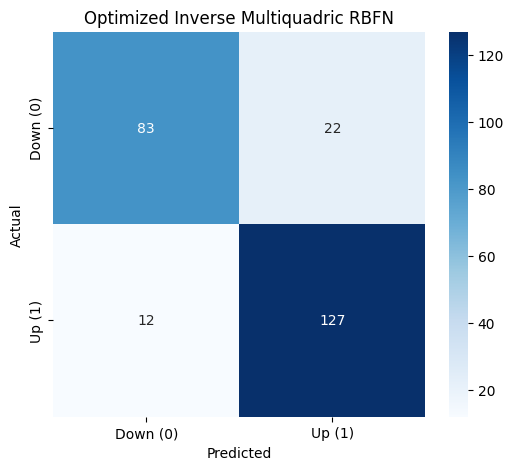

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import optuna

# Set seed
np.random.seed(42)

# Load dataset
df = pd.read_csv("SENSEX_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Inverse Multiquadric RBFN Class ---
class InverseMultiquadricRBFN:
    def __init__(self, num_neurons, c=1.0, gamma=1.0, reg_param=0.0):
        self.num_neurons = num_neurons
        self.c = c  # Shape parameter for inverse multiquadric
        self.gamma = gamma  # Scale parameter
        self.reg_param = reg_param

    def _basis(self, r, center=0.0):
        return 1.0 / np.sqrt(1 + self.gamma * (r - center)**2 / self.c**2)

    def _calculate_interpolation_matrix(self, X, centers):
        G = np.zeros((X.shape[0], centers.shape[0]))
        for i, center in enumerate(centers):
            r = np.linalg.norm(X - center, axis=1)
            G[:, i] = self._basis(r)
        return G

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_

        G = self._calculate_interpolation_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))  # Add bias term

        I = np.identity(G.shape[1])
        I[0, 0] = 0  # No regularization for bias
        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X, return_proba=False):
        G = self._calculate_interpolation_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_score = G @ self.weights

        if return_proba:
            return 1 / (1 + np.exp(-y_score))  # Sigmoid for probabilities
        return (y_score > 0.5).astype(int)

# --- Optuna Objective ---
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    c = trial.suggest_float("c", 0.1, 10.0, log=True)  # Shape parameter
    gamma = trial.suggest_float("gamma", 0.001, 10.0, log=True)  # Scale parameter
    reg_param = trial.suggest_float("reg_param", 1e-6, 1.0, log=True)

    model = InverseMultiquadricRBFN(
        num_neurons=num_neurons,
        c=c,
        gamma=gamma,
        reg_param=reg_param
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

# --- Run Optuna ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# --- Best Model Evaluation ---
best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = InverseMultiquadricRBFN(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_proba = final_model.predict(X_test, return_proba=True)

# --- Metrics ---
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"],
            yticklabels=["Down (0)", "Up (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized Inverse Multiquadric RBFN")
plt.show()


## Fractalized inverse multi-quadric

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import optuna

# Base RBF and base function - Modified for Inverse Multiquadric
def classical_inverse_multiquadric_rbf(r, center=0.0, c=1.0, gamma=1.0):
    return 1.0 / np.sqrt(1 + gamma * (r - center)**2 / c**2)

def base_function(r, center=0.0, c=1.0, gamma=1.0):
    r0, r1 = 0, np.sqrt(6)
    phi0 = classical_inverse_multiquadric_rbf(r0, center=center, c=c, gamma=gamma)
    phi1 = classical_inverse_multiquadric_rbf(r1, center=center, c=c, gamma=gamma)
    return (phi1 - phi0) / (r1 - r0) * r + phi0

# Affine mapping functions
def u_i(i, r, intervals):
    a = (intervals[i] - intervals[i-1]) / (intervals[-1] - intervals[0])
    b = intervals[i-1] - a * intervals[0]
    return a * r + b

def v_i(i, r, t, alpha, intervals, center=0.0, c=1.0, gamma=1.0):
    phi_val = classical_inverse_multiquadric_rbf(u_i(i, r, intervals), center=center, c=c, gamma=gamma)
    base_val = base_function(r, center=center, c=c, gamma=gamma)
    return phi_val + alpha[i-1] * (t - base_val)

# Fractal iteration with recursive point generation
def iterate_fractal_operator(alpha, intervals, center=0.0, c=1.0, gamma=1.0, max_iter=4):
    r_list = [np.array([0.0, np.sqrt(6)])]
    phi_dict = {}

    # Base evaluation
    r0 = r_list[0]
    phi0 = base_function(r0, center=center, c=c, gamma=gamma)
    phi_dict[0] = phi0

    for d in range(1, max_iter + 1):
        r_prev = r_list[-1]
        r_new = []
        phi_new = []

        for i in range(1, len(intervals)):
            r_i = u_i(i, r_prev, intervals)
            t_i = phi_dict[d - 1]

            # Map inverse from u_i
            r_inv = (r_i - intervals[i-1]) / (intervals[i] - intervals[i-1])
            v_vals = v_i(i, r_inv, t_i, alpha, intervals, center=center, c=c, gamma=gamma)

            r_new.extend(r_i)
            phi_new.extend(v_vals)

        # Sort and deduplicate
        r_new = np.array(r_new)
        phi_new = np.array(phi_new)
        sort_idx = np.argsort(r_new)
        r_new = r_new[sort_idx]
        phi_new = phi_new[sort_idx]

        r_list.append(r_new)
        phi_dict[d] = phi_new

    return r_list[-1], phi_dict[max_iter]

# ----------------- RBF Model Class ------------------
class FractalizedRBFN_InverseMultiquadric:
    def __init__(self, num_neurons, alpha_list, reg_param=0.0, c=1.0, gamma=1.0, max_iter=4):
        self.num_neurons = num_neurons
        self.alpha_list = alpha_list
        self.reg_param = reg_param
        self.c = c  # Shape parameter for inverse multiquadric
        self.gamma = gamma
        self.intervals = [0, np.sqrt(6)/2, np.sqrt(6)]
        self.max_iter = max_iter

    def _fractalized_basis(self, r, center):
        r_vals, phi_vals = iterate_fractal_operator(
            self.alpha_list, self.intervals,
            center=center, c=self.c, gamma=self.gamma,
            max_iter=self.max_iter
        )
        return np.interp(r, r_vals, phi_vals)

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))  # bias
        I = np.identity(G.shape[1])
        I[0, 0] = 0  # no regularization on bias

        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X, return_proba=False):
        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_score = G @ self.weights

        if return_proba:
            return 1 / (1 + np.exp(-y_score))  # sigmoid transformation
        else:
            return (y_score > 0.5).astype(int)

# ----------------- Optuna Hyperparameter Tuning ------------------
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    alpha1 = trial.suggest_float("alpha1", -0.5, 0.5)
    alpha2 = trial.suggest_float("alpha2", -0.5, 0.5)
    reg_param = trial.suggest_float("reg_param", 0.001, 0.1, log=True)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)
    c = trial.suggest_float("c", 0.1, 2.0)  # Shape parameter for inverse multiquadric
    max_iter = trial.suggest_int("max_iter", 2, 5)

    model = FractalizedRBFN_InverseMultiquadric(
        num_neurons=num_neurons,
        alpha_list=[alpha1, alpha2],
        reg_param=reg_param,
        c=c,
        gamma=gamma,
        max_iter=max_iter
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

# ----------------- Load Data ------------------
df = pd.read_csv("SENSEX_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Run Optuna ------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# ----------------- Best Model Evaluation ------------------
best_params = study.best_params
print("Best Parameters:", best_params)

best_model = FractalizedRBFN_InverseMultiquadric(
    num_neurons=best_params['num_neurons'],
    alpha_list=[best_params['alpha1'], best_params['alpha2']],
    reg_param=best_params['reg_param'],
    c=best_params['c'],
    gamma=best_params['gamma'],
    max_iter=best_params['max_iter']
)
best_model.fit(X_train, y_train)

# Evaluation metrics and plots
y_pred = best_model.predict(X_test)
y_score = best_model.predict(X_test, return_proba=True)

print("\nPerformance Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[I 2025-05-13 06:23:00,361] A new study created in memory with name: no-name-201e2e84-5582-430b-bb68-07cbd13694f1
[I 2025-05-13 06:23:00,414] Trial 0 finished with value: 0.789272030651341 and parameters: {'num_neurons': 54, 'alpha1': -0.3164480829582702, 'alpha2': 0.22824655893446033, 'reg_param': 0.0018813800729296005, 'gamma': 1.5907040040006075, 'c': 0.1690438864087962, 'max_iter': 5}. Best is trial 0 with value: 0.789272030651341.
[I 2025-05-13 06:23:00,476] Trial 1 finished with value: 0.7272727272727273 and parameters: {'num_neurons': 27, 'alpha1': 0.3430338961273419, 'alpha2': -0.2553198829063811, 'reg_param': 0.0019213568898099635, 'gamma': 2.0340620003334227, 'c': 1.2019646846304528, 'max_iter': 5}. Best is trial 0 with value: 0.789272030651341.
[I 2025-05-13 06:23:00,641] Trial 2 finished with value: 0.8032128514056225 and parameters: {'num_neurons': 170, 'alpha1': 0.1568222993306957, 'alpha2': -0.009666357939004722, 'reg_param': 0.04128090962975782, 'gamma': 2.0314143687867

Best Parameters: {'num_neurons': 113, 'alpha1': 0.33063718528133484, 'alpha2': 0.2454508086168844, 'reg_param': 0.07807037347312339, 'gamma': 4.873573376511152, 'c': 0.2787601627752846, 'max_iter': 2}

Performance Metrics:
Accuracy: 0.8634538152610441
F1 Score: 0.8650793650793651
Confusion Matrix:
 [[106  23]
 [ 11 109]]
